## Load data

In [5]:
import pandas as pd
import ast
import numpy as np

# Load in data
admissions = 'tedsa_puf_2019.csv'
df_raw = pd.read_csv(f'../../Downloads/{admissions}')

## Filter out select rows and columns

In [6]:
# Get count of original number of rows
old_rows = len(df_raw)

# Drop defined columns (year of admission, case id, geographic metro area, geographic division, geographic region)
# columns_to_drop = ['ADMYR', 'CASEID', 'CBSA2010', 'DIVISION', 'REGION']
columns_to_drop = ['ADMYR', 'CASEID', 'CBSA2010']
df = df_raw.drop(columns=columns_to_drop)
print(f'Dropped {len(columns_to_drop)} columns ({len(df.columns)} remain)')

# Drop values where dependent variable is unknown
df = df[df['METHUSE'] != -9]

# Only keep patients admitted with self-described use of an opioid as their primary substance use (i.e., SUB1 = 5, 6, or 7)
df = df[df['SUB1'].between(5, 7)]
new_rows = len(df)
percent_change = round(100*(old_rows-new_rows)/old_rows, 1)
print(f'Dropped {"{:,}".format(old_rows-new_rows)} observations or {percent_change}% of the data ({"{:,}".format(new_rows)} rows remain)')

df = df.reset_index(drop='index')

Dropped 3 columns (59 remain)
Dropped 1,340,233 observations or 71.9% of the data (524,134 rows remain)


## Balance dataset

In [7]:
# Split into two dataframes, printing result
df_ones = df[df['METHUSE']==1]
df_twos = df[df['METHUSE']==2]
print('Classes before down-sampling:', len(df_ones), len(df_twos))

# Sample down df_twos to the length of df_ones, printing result
ratio = len(df_ones)/len(df_twos)
df_twos = df_twos.sample(frac=ratio)
print('Classes after down-sampling:', len(df_ones), len(df_twos))

# Recombine and shuffle for good measure
df = pd.concat([df_ones, df_twos], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

Classes before down-sampling: 211743 312391
Classes after down-sampling: 211743 211743


## Make dataset human-readable

In [8]:
# Load in variable dictionary
with open('VariableDictionary.txt') as file:
    variable_dict_string = file.read()
    variable_dict = ast.literal_eval(variable_dict_string)

# Rename entries in column according to dictionary
df2 = df.copy()
for col, col_dict in variable_dict.items():
    if col in df2.columns:
        for old_value, new_value in variable_dict[col].items():
            df2[col] = df2[col].replace(old_value, new_value)

# Rename "-9" values as "Unknown"
for col in df2.columns:
    df2[col] = df2[col].replace(-9, 'Unknown')

# Merge DETNLF (detailed not in labor force) into EMPLOY==4 (not in labor force)
detailed_employ = []

for idx, value in df2.iterrows():
    if value['EMPLOY'] == 'NotInLaborForce':
        if value['DETNLF'] == 'Unknown':
            # Assign 'UnknownNotInLaborForce' if 'NotInLaborForce' and 'Unknown'
            detailed_employ.append('UnknownNotInLaborForce')
        else:
            # Otherwise, assign as the DETNLF value
            detailed_employ.append(value['DETNLF'])
    else:
        # Assign the EMPLOY value if not 'NotInLaborForce'
        detailed_employ.append(value['EMPLOY'])

# Add a new column for detailed employment and drop the two source columns
df2['DETEMPLOY'] = detailed_employ
df2 = df2.drop(columns=['EMPLOY', 'DETNLF'])

# Convert dependent variable to binary integer
df2['METHUSE'] = df2['METHUSE'].replace('MethUse', 1)
df2['METHUSE'] = df2['METHUSE'].replace('NoMethUse', 0)

# XGBoost and Shapley

### Make machine-readable dataset (encoding)

In [9]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

df4 = df2.copy()
# df4 = df4.sample(frac=0.1)  # small size for testing code

df4['STFIPS'] = df4['STFIPS'].astype('category').cat.codes
df4['EDUC'] = OrdinalEncoder(categories=[['Unknown', 'Grade8OrLess', 'Grade9To11', 'Grade12OrGED', '1To3yCollege', '4yCollegePlus']]).fit_transform(df4[['EDUC']])
df4['MARSTAT'] = df4['MARSTAT'].astype('category').cat.codes
df4['SERVICES'] = df4['SERVICES'].astype('category').cat.codes
df4['DETCRIM'] = df4['DETCRIM'].astype('category').cat.codes
df4['NOPRIOR'] = OrdinalEncoder(categories=[['Unknown', '0PriorTreatments', '1PriorTreatments', '2PriorTreatments', '3PriorTreatments',
                                            '4PriorTreatments', '5PlusPriorTreatments']]).fit_transform(df4[['NOPRIOR']])
df4['PSOURCE'] = df4['PSOURCE'].astype('category').cat.codes
df4['ARRESTS'] = OrdinalEncoder(categories=[['Unknown', '0Arrest', '1Arrest', '2PlusArrest']]).fit_transform(df4[['ARRESTS']])
# df4['METHUSE'] = df4['METHUSE'].astype('category').cat.codes
df4['PSYPROB'] = df4['PSYPROB'].astype('category').cat.codes
df4['PREG'] = df4['PREG'].astype('category').cat.codes
df4['GENDER'] = df4['GENDER'].astype('category').cat.codes
df4['VET'] = df4['VET'].astype('category').cat.codes
df4['LIVARAG'] = df4['LIVARAG'].astype('category').cat.codes
df4['DAYWAIT'] = OrdinalEncoder(categories=[['Unknown', '0DaysWait', '1To7DaysWait', '8To14DaysWait', '15To30DaysWait',
                                            '31PlusDaysWait']]).fit_transform(df4[['DAYWAIT']])
df4['DSMCRIT'] = df4['DSMCRIT'].astype('category').cat.codes
df4['AGE'] = OrdinalEncoder(categories=[['Age12To14', 'Age15To17', 'Age18To20', 'Age21To24', 'Age25To29', 'Age30To34', 'Age35To39', 'Age40To44',
                                        'Age45To49', 'Age50To54', 'Age55To64', 'Age65Plus' ]]).fit_transform(df4[['AGE']])
df4['RACE'] = df4['RACE'].astype('category').cat.codes
df4['ETHNIC'] = df4['ETHNIC'].astype('category').cat.codes
df4['PRIMINC'] = df4['PRIMINC'].astype('category').cat.codes
df4['SUB1'] = df4['SUB1'].astype('category').cat.codes
df4['SUB2'] = df4['SUB2'].astype('category').cat.codes
df4['SUB3'] = df4['SUB3'].astype('category').cat.codes
df4['ROUTE1'] = df4['ROUTE1'].astype('category').cat.codes
df4['ROUTE2'] = df4['ROUTE2'].astype('category').cat.codes
df4['ROUTE3'] = df4['ROUTE3'].astype('category').cat.codes
df4['FREQ1'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ1']])
df4['FREQ2'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ2']])
df4['FREQ3'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ3']])
df4['FRSTUSE1'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE1']])
df4['FRSTUSE2'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE2']])
df4['FRSTUSE3'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE3']])
df4['HLTHINS'] = df4['HLTHINS'].astype('category').cat.codes
df4['PRIMPAY'] = df4['PRIMPAY'].astype('category').cat.codes
df4['FREQ_ATND_SELF_HELP'] = OrdinalEncoder(categories=[['Unknown', 'NoAttendance', 'SomeAttendance', '1To3TimesPastMonth', '4To7TimesPastMonth',
                                                        '8To30TimesPastMonth']]).fit_transform(df4[['FREQ_ATND_SELF_HELP']])
df4['ALCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['ALCFLG']])
df4['COKEFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['COKEFLG']])
df4['MARFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MARFLG']])
df4['HERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HERFLG']])
df4['METHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['METHFLG']])
df4['OPSYNFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OPSYNFLG']])
df4['PCPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['PCPFLG']])
df4['HALLFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HALLFLG']])
df4['MTHAMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MTHAMFLG']])
df4['AMPHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['AMPHFLG']])
df4['STIMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['STIMFLG']])
df4['BENZFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BENZFLG']])
df4['TRNQFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['TRNQFLG']])
df4['BARBFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BARBFLG']])
df4['SEDHPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['SEDHPFLG']])
df4['INHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['INHFLG']])
df4['OTCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTCFLG']])
df4['OTHERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTHERFLG']])
df4['DIVISION'] = df4['DIVISION'].astype('category').cat.codes
df4['REGION'] = df4['REGION'].astype('category').cat.codes
df4['IDU'] = OrdinalEncoder(categories=[['NoIDU', 'IDU']]).fit_transform(df4[['IDU']])
df4['ALCDRUG'] = OrdinalEncoder(categories=[['OtherDrugs', 'AlcoholAndDrugs']]).fit_transform(df4[['ALCDRUG']])
df4['DETEMPLOY'] = df4['DETEMPLOY'].astype('category').cat.codes

## Train XG Boost model

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X = df4.drop('METHUSE', axis=1)
y = df4['METHUSE'].astype('float')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Search the parameter grid
# Docs: https://xgboost.readthedocs.io/en/latest/parameter.html
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook#2.-XGBoost-hyperparameters-
defined_space={'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.01),
       'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
       'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
       'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
       'max_depth': hp.quniform("max_depth", 3, 27, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.choice('n_estimators', range(100, 1000)),
       'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
       'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
       'subsample': hp.quniform('subsample', 0.5, 1, 0.05)
    }

def objective(space):
    clf = xgb.XGBClassifier(colsample_bytree=round(space['colsample_bytree'], 0),
                          early_stopping_rounds=10,
                          eta=space['eta'],
                          eval_metric='auc',
                          gamma=space['gamma'],
                          learning_rate=space['learning_rate'],
                          max_depth=int(round(space['max_depth'], 0)),
                          min_child_weight=space['min_child_weight'],
                          n_estimators=space['n_estimators'],
                          objective='binary:logistic',
                          reg_alpha=space['reg_alpha'],
                          reg_lambda=space['reg_lambda'],
                          seed=24,
                          subsample=round(space['subsample'], 0))

    # Evaluate the model and record performance metrics
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    clf.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test,y_pred)

    print (f"Accuracy: {round(accuracy, 4)}, AUC: {round(auc, 4)}")
    return {'loss': -accuracy, 'status': STATUS_OK }

In [23]:
# Begin training
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = defined_space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

Accuracy: 0.8437, AUC: 0.9286                           
Accuracy: 0.8441, AUC: 0.9284                                                        
Accuracy: 0.8394, AUC: 0.925                                                         
Accuracy: 0.7601, AUC: 0.8334                                                        
Accuracy: 0.6563, AUC: 0.7149                                                        
Accuracy: 0.8496, AUC: 0.9336                                                        
Accuracy: 0.6164, AUC: 0.6656                                                        
Accuracy: 0.6652, AUC: 0.7231                                                        
Accuracy: 0.8395, AUC: 0.9247                                                        
Accuracy: 0.8447, AUC: 0.9294                                                        
Accuracy: 0.8394, AUC: 0.9255                                                         
Accuracy: 0.8367, AUC: 0.9232                                                     

In [24]:
"""
# Best from 100 runs (without REGION, DIVISION)

 {'colsample_bytree': 0.61,
 'eta': 0.25,
 'gamma': 0.8,
 'learning_rate': 0.22,
 'max_depth': 16.0,
 'min_child_weight': 0.0,
 'n_estimators': 812,
 'reg_alpha': 40.0,
 'reg_lambda': 0.9241629285526229,
 'subsample': 0.9}
"""

# best_hyperparams = {'colsample_bytree': 0.61,
#                      'eta': 0.25,
#                      'gamma': 0.8,
#                      'learning_rate': 0.22,
#                      'max_depth': 16.0,
#                      'min_child_weight': 0.0,
#                      'n_estimators': 812,
#                      'reg_alpha': 40.0,
#                      'reg_lambda': 0.9241629285526229,
#                      'subsample': 0.9}

# Best from 100 runs (85% accuracy, 0.933 AUC)
""""
 {'colsample_bytree': 0.5700000000000001,
 'eta': 0.25,
 'gamma': 0.6000000000000001,
 'learning_rate': 0.26,
 'max_depth': 19.0,
 'min_child_weight': 0.0,
 'n_estimators': 525,
 'reg_alpha': 47.0,
 'reg_lambda': 0.4282630657696102,
 'subsample': 0.75}
"""

# best_hyperparams = {'colsample_bytree': 0.57,
#                      'eta': 0.25,
#                      'gamma': 0.6,
#                      'learning_rate': 0.26,
#                      'max_depth': 19.0,
#                      'min_child_weight': 0.0,
#                      'n_estimators': 525,
#                      'reg_alpha': 47.0,
#                      'reg_lambda': 0.4282630657696102,
#                      'subsample': 0.75}

# Best from 1000 runs
""""
{'colsample_bytree': 0.62,
 'eta': 0.30000000000000004,
 'gamma': 0.5,
 'learning_rate': 0.18,
 'max_depth': 27.0,
 'min_child_weight': 0.0,
 'n_estimators': 637,
 'reg_alpha': 40.0,
 'reg_lambda': 0.9778997768026216,
 'subsample': 0.8500000000000001}
"""

# best_hyperparams = {'colsample_bytree': 0.62,
#                      'eta': 0.30,
#                      'gamma': 0.5,
#                      'learning_rate': 0.18,
#                      'max_depth': 27.0,
#                      'min_child_weight': 0.0,
#                      'n_estimators': 637,
#                      'reg_alpha': 40.0,
#                      'reg_lambda': 0.9778997768026216,
#                      'subsample': 0.85}

best_hyperparams

{'colsample_bytree': 0.62,
 'eta': 0.30000000000000004,
 'gamma': 0.5,
 'learning_rate': 0.18,
 'max_depth': 27.0,
 'min_child_weight': 0.0,
 'n_estimators': 637,
 'reg_alpha': 40.0,
 'reg_lambda': 0.9778997768026216,
 'subsample': 0.8500000000000001}

In [25]:
# Train best model
best_hyperparams_formatted = best_hyperparams.copy()
best_hyperparams_formatted['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams_formatted['eval_metric'] = 'auc'
best_hyperparams_formatted['objective'] = 'binary:logistic'
best_hyperparams_formatted['seed'] = 24

best_model = xgb.XGBClassifier(**best_hyperparams_formatted)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.62, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.30000000000000004,
              eval_metric='auc', feature_types=None, gamma=0.5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=27, max_leaves=None,
              min_child_weight=0.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=637, n_jobs=None,
              num_parallel_tree=None, ...)

In [26]:
# Evaluate the model and record performance metrics
evaluation = [( X_train, y_train), ( X_test, y_test)]
best_pred = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, best_pred>0.5)
y_best_pred = best_model.predict_proba(X_test)[:,1]
best_auc = roc_auc_score(y_test,y_best_pred)

print (f"Accuracy: {round(best_accuracy, 4)}, AUC: {round(best_auc, 4)}")

Accuracy: 0.8518, AUC: 0.9351


### Interpretability

In [27]:
import shap
import numpy as np

# Generate Shapley values
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

[11:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [28]:
shap_values   # Can we export these values as a csv? Trying to find a way to not have to run them each time

.values =
array([[-2.72757895e-02,  3.42021286e-02,  3.73061784e-02, ...,
         2.80914884e-02,  6.93892129e-03,  2.36243457e-02],
       [-4.01583374e-01, -2.32076552e-02,  3.59664368e-03, ...,
         1.31237805e-02, -5.81168337e-04, -1.92546368e-01],
       [-1.32091586e-02, -8.79201367e-02, -6.49405479e-01, ...,
        -3.67406234e-02,  1.60335726e-03, -6.76377863e-02],
       ...,
       [ 4.61404532e-01, -4.84171025e-02,  7.41933333e-03, ...,
         4.33878638e-02,  5.57194650e-03, -1.07471779e-01],
       [ 5.78675233e-02, -2.56198272e-02, -3.41308080e-02, ...,
        -8.98936577e-03,  6.55724620e-03,  1.59859117e-02],
       [-3.40169877e-01,  3.70564274e-02, -4.66050906e-03, ...,
        -4.11690511e-02,  2.54947064e-03, -3.58299278e-02]], dtype=float32)

.base_values =
array([-0.01371378, -0.01371378, -0.01371378, ..., -0.01371378,
       -0.01371378, -0.01371378], dtype=float32)

.data =
array([[ 4.,  3.,  4., ...,  1.,  0.,  4.],
       [18.,  3.,  1., ...,  1.,  0.

In [29]:
import os
os.system('say "Work complete"')

0

In [30]:
def absolute_share(input_list):
    absolute_list = [abs(i) for i in input_list]
    absolute_share_list = [j/sum(absolute_list) for j in absolute_list]
    return absolute_share_list

# Show table of top Shapley values
feature_names = X.columns
result = pd.DataFrame(shap_values.values, columns=feature_names, index=X.index)
# result.to_csv('shapley_results.csv', index=False)

values = np.abs(result.values).mean(0)
abs_values = absolute_share(np.abs(result.values).mean(0))
shap_importance = pd.DataFrame(list(zip(feature_names, values, abs_values)), columns=['feature_name','feature_importance', 'feature_importance_out_of_100'])
shap_importance.sort_values(by=['feature_importance'], ascending=False, inplace=True)
shap_importance.reset_index(drop=True)

,feature_name,feature_importance,feature_importance_out_of_100
0,SERVICES,1.246796,0.244564
1,STFIPS,0.527862,0.103542
2,REGION,0.326182,0.063982
3,DIVISION,0.323002,0.063358
4,PSOURCE,0.320034,0.062776
5,NOPRIOR,0.204219,0.040058
6,FREQ1,0.162377,0.031851
7,DSMCRIT,0.115971,0.022748
8,FREQ_ATND_SELF_HELP,0.105577,0.020709
9,PSYPROB,0.103412,0.020285


In [146]:
# (-0.1199*12982 + -0.0953*13336 + 0.0634*53816 + -0.0368*4564)/(12982 + 13336 + 53816 + 4564)
(0.1295*12982 + 0.0995*13336 + 0.0641*53816 + 0.0630*4564)/(12982 + 13336 + 53816 + 4564)

0.07963869985123616

In [147]:
livarag_dict = {0:'DependLiving', 1:'Homeless', 2:'IndependentLiving', 3:'Unknown'}
print(livarag_dict)
X.value_counts('LIVARAG')
# df2.value_counts('LIVARAG')

{0: 'DependLiving', 1: 'Homeless', 2: 'IndependentLiving', 3: 'Unknown'}


LIVARAG
2    268885
1     66100
0     65813
3     22688
dtype: int64

In [31]:
# result = pd.read_csv('shapley_results.csv')
result_homeless = result.copy()
result_homeless.insert(0, 'homeless', X['LIVARAG'])
result_homeless.insert(1, 'absolute_livarag', abs(result_homeless['LIVARAG']))
result_homeless_grouped = result_homeless.groupby('homeless').mean()[['LIVARAG', 'absolute_livarag']]
result_homeless_var = result_homeless_grouped.iloc[1]['LIVARAG']
result_homeless_grouped

,LIVARAG,absolute_livarag
homeless,,
0,-0.120074,0.123803
1,-0.057808,0.065919
2,0.062850,0.062943
3,-0.108292,0.117648


In [32]:
# Group by state for three known groups
# Split into three dataframes
df2_homeless = df2[df2['LIVARAG']=='Homeless'][['STFIPS']]
df2_independent = df2[df2['LIVARAG']=='IndependentLiving'][['STFIPS']]
df2_dependent = df2[df2['LIVARAG']=='DependLiving'][['STFIPS']]

# Merge with Shapley values
result_shapley = result[['LIVARAG']].rename(columns={'LIVARAG':'livarag_shapley'})
result_state_homeless = pd.merge(result_shapley, df2_homeless, how='inner', left_index=True, right_index=True)
result_state_independent = pd.merge(result_shapley, df2_independent, how='inner', left_index=True, right_index=True)
result_state_dependent = pd.merge(result_shapley, df2_dependent, how='inner', left_index=True, right_index=True)
result_state_housed = pd.concat([result_state_independent, result_state_dependent], axis=0)

# Group to state-level averages and merge
result_state_homeless_mean = result_state_homeless.groupby('STFIPS').mean().rename(columns={'livarag_shapley':'homeless_shapley'})
result_state_housed_mean = result_state_housed.groupby('STFIPS').mean().rename(columns={'livarag_shapley':'housed_shapley'})
result_state_mean = result_state_homeless_mean.copy()
result_state_mean['housed_shapley'] = result_state_housed_mean['housed_shapley']

# Add national averages
homeless_avg = result_state_homeless['livarag_shapley'].mean()
housed_avg = result_state_housed['livarag_shapley'].mean()
national_avg = pd.DataFrame(data={'homeless_shapley':[homeless_avg], 'housed_shapley':housed_avg}, index=['USA'])
result_state_mean = pd.concat([result_state_mean, national_avg], axis=0)

# Calculate difference and ttest
result_state_mean['difference_shapley'] = result_state_mean['homeless_shapley']-result_state_mean['housed_shapley']

# Save, print results
# result_state_mean.to_csv('shap_importance_by_state.csv')
result_state_mean

,homeless_shapley,housed_shapley,difference_shapley
AK,-0.019170,0.030995,-0.050165
AL,-0.033164,-0.001429,-0.031735
AR,-0.066827,0.014993,-0.081819
CA,-0.117790,0.037434,-0.155224
CO,-0.018993,0.031412,-0.050406
CT,-0.051676,0.038167,-0.089843
DC,-0.067285,-0.026174,-0.041111
DE,-0.088398,0.042155,-0.130554
GA,-0.074296,-0.011210,-0.063087
HI,-0.057522,-0.010795,-0.046727


### Add t-test

In [34]:
import numpy as np
from scipy.stats import ttest_ind

# Merge with Shapley values
df2_1 = df2[df2['LIVARAG'] != 'Unknown']
result_shapley = result[['LIVARAG']].rename(columns={'LIVARAG':'livarag_shapley'})
result_state = pd.merge(result_shapley, df2_1[['STFIPS', 'LIVARAG']], how='inner', left_index=True, right_index=True)
result_state['LIVARAG'] = result_state['LIVARAG'].replace(['IndependentLiving', 'DependLiving'], 'Housed')

# Duplicate results listing them as national
result_national = result_state.copy()
result_national['STFIPS'] = 'USA'
result_state_national = pd.concat([result_state, result_national])
result_state_national = result_state_national.reset_index(drop=True)

# Create assets for loop
state_array = result_state_national['STFIPS'].sort_values().unique()
state_list = state_array.tolist()
state_list.append('USA')
df_state = pd.DataFrame(columns=['Homeless', 'Housed', 'Difference', 'TStat', 'PValue', 'Significance'])

# Loop through each state
for s in state_list:
    dftemp = result_state_national[result_state_national['STFIPS'] == s]

    # Group by living arrangement and MOUD, then store those variables for later (if they exist)
    dft_grouped = dftemp.groupby('LIVARAG')['livarag_shapley'].mean()

    try:
        homeless_moud = dft_grouped.loc['Homeless']
    except KeyError:
        print(f"Insufficient homeless admissions to form a group in {s}")
        homeless_moud = np.nan

    try:
        housed_moud = dft_grouped.loc['Housed']
    except KeyError:
        print(f"Insufficient housed admissions to form a group in {s}")
        housed_moud = np.nan

    # Perform a t-test between the two groups
    group_A_values = dftemp[dftemp['LIVARAG'] == 'Homeless']['livarag_shapley']
    group_B_values = dftemp[dftemp['LIVARAG'] == 'Housed']['livarag_shapley']
    t_stat, p_value = ttest_ind(group_A_values, group_B_values)

    # Add significance based on p-value
    if p_value < 0.001:
        significance = '****'
    elif p_value < 0.01:
        significance = '***'
    elif p_value < 0.05:
        significance = '**'
    elif p_value <0.1:
        significance = '*'
    else:
        significance = ''

    # Add values to a dictionary and round
    dict_results = {'Homeless':homeless_moud, 'Housed':housed_moud, 'Difference':homeless_moud-housed_moud, 'TStat':t_stat, 'PValue':p_value}
    for key, value in dict_results.items():
        dict_results[key] = round(value, 6)

    # Add significance and to dictionary and then dictionary to dataframe
    dict_results['Significance'] = significance
    df_state.loc[s] = dict_results

# df_state.to_csv('shapley_with_ttest.csv') #uncomment to save file
df_state

,Homeless,Housed,Difference,TStat,PValue,Significance
AK,-0.019170,0.030995,-0.050165,-15.556488,0.000000,****
AL,-0.033164,-0.001429,-0.031735,-8.080899,0.000000,****
AR,-0.066827,0.014993,-0.081819,-13.678728,0.000000,****
CA,-0.117790,0.037434,-0.155224,-278.545366,0.000000,****
CO,-0.018993,0.031412,-0.050406,-23.666658,0.000000,****
CT,-0.051676,0.038167,-0.089843,-65.517994,0.000000,****
DC,-0.067285,-0.026174,-0.041111,-9.023708,0.000000,****
DE,-0.088398,0.042155,-0.130554,-54.590180,0.000000,****
GA,-0.074296,-0.011210,-0.063087,-9.733770,0.000000,****
HI,-0.057522,-0.010795,-0.046727,-5.707689,0.000000,****


# Plot Shapley values

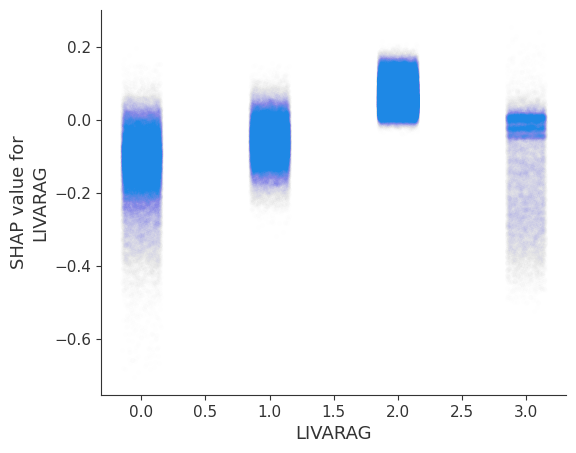

In [35]:
# Show dependence plots for the top n features across all observations
# NOTE: In order to get dependence plot to work, you must revert to matplotlib==3.1.3
# Examples of dependence plots: https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

shap.dependence_plot('LIVARAG', shap_values.values, X, x_jitter=0.3, alpha=0.005, interaction_index=None)

In [36]:
shap_importance

,feature_name,feature_importance,feature_importance_out_of_100
3,SERVICES,1.246796,0.244564
0,STFIPS,0.527862,0.103542
53,REGION,0.326182,0.063982
52,DIVISION,0.323002,0.063358
6,PSOURCE,0.320034,0.062776
5,NOPRIOR,0.204219,0.040058
25,FREQ1,0.162377,0.031851
14,DSMCRIT,0.115971,0.022748
33,FREQ_ATND_SELF_HELP,0.105577,0.020709
8,PSYPROB,0.103412,0.020285


In [37]:
shap_importance
# shap_importance.to_csv('shap_importance.csv', index=False)

# Grouped feature importance

In [5]:
import pandas as pd
g = pd.read_csv('shap_importance_encoded.csv')  #update label and category, then regroup
g

,feature_name,feature_label,feature_category,feature_importance,feature_importance_out_of_100
0,SERVICES,treatment service,coordination of care,1.169295,0.221355
1,STFIPS,state code,geographic,0.808112,0.152981
2,PSOURCE,referral source,coordination of care,0.297946,0.056403
3,NOPRIOR,prior treatments,medical history,0.260033,0.049226
4,HLTHINS,health insurance,economic,0.209499,0.039660
5,FREQ1,primary frequency,substance use history,0.171629,0.032491
6,DSMCRIT,dsm diagnosis,medical history,0.164464,0.031134
7,FREQ_ATND_SELF_HELP,self help group,medical history,0.139806,0.026466
8,PRIMINC,income source,economic,0.130791,0.024760
9,PRIMPAY,payment source,economic,0.129681,0.024550


In [7]:
g_grouped = g.groupby('feature_category').sum()['feature_importance_out_of_100'].sort_values(ascending=False)
# g_grouped.to_csv('shap_importance_grouped.csv')
g_grouped

feature_category
coordination of care     0.311856
substance use history    0.197930
geographic               0.152981
medical history          0.135583
economic                 0.126462
demographic              0.037923
personal history         0.037266
Name: feature_importance_out_of_100, dtype: float64

In [8]:
g.sort_values(by='feature_importance_out_of_100', ascending=False)[['feature_label', 'feature_importance_out_of_100']].reset_index(drop=True)

,feature_label,feature_importance_out_of_100
0,treatment service,0.221355
1,state code,0.152981
2,referral source,0.056403
3,prior treatments,0.049226
4,health insurance,0.039660
5,primary frequency,0.032491
6,dsm diagnosis,0.031134
7,self help group,0.026466
8,income source,0.024760
9,payment source,0.024550
